In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import seaborn as sns
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random
import torch
import torch.nn as nn
from torchvision import models
import os
import torch
from tqdm.autonotebook import tqdm

/tmp/ipykernel_19/2837484002.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
def set_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [3]:
SEED = 42
set_seed(SEED)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
import kagglehub
import os


print("Downloading the dataset...")
path = kagglehub.dataset_download("mohamedasak/chest-x-ray-6-classes-dataset")
print("Dataset downloaded successfully.")


data_root = os.path.join(path, 'chest-xray')

print("Path to the dataset files:", data_root)

Dataset downloaded successfully.
Path to the dataset files: /kaggle/input/chest-x-ray-6-classes-dataset/chest-xray


In [6]:

save_directory = "/content/drive/MyDrive/my_project/models"
best_model_path = os.path.join(save_directory, "best_model.pth")
os.makedirs(os.path.dirname(best_model_path), exist_ok=True)


In [7]:

temp_train_dataset = ImageFolder(root=os.path.join(data_root, 'train'))

class_counts = [0] * len(temp_train_dataset.classes)
for _, label in temp_train_dataset:
  class_counts[label] += 1

print("Number of images per category:", class_counts)

# حساب أوزان الفئات (Inverse Frequency)
total_samples = sum(class_counts)
num_classes = len(class_counts)
class_weights = total_samples / (num_classes * np.array(class_counts))
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

print("Calculated class weights:", class_weights)


Number of images per category: [2417, 2050, 2671, 2400, 2413, 2600]
Calculated class weights: tensor([1.0034, 1.1830, 0.9080, 1.0105, 1.0050, 0.9328], device='cuda:0')



## Handling Data Imbalance
During my exploration of the training dataset, I noticed that the number of images varies slightly across different classes. This imbalance, while minor, could potentially bias the model's performance towards classes with more images.

Here are the initial image counts for each class:

Image counts per class: [2417, 2050, 2671, 2400, 2413, 2600]

As you can see from the numbers, the class with 2050 images is the least represented, while the one with 2671 images is the most represented. To tackle this, I've decided to apply a Class Weighting technique using the Inverse Frequency method.

This approach gives a higher weight to the underrepresented classes and a lower weight to the more common ones. By doing this, I ensure that the model pays more attention to the rare classes during training, which reduces bias and improves overall performance.

After applying the method, I obtained the following weights:

Calculated class weights: tensor([1.0034, 1.1830, 0.9080, 1.0105, 1.0050, 0.9328], device='cuda:0')

The weights make perfect sense:

The highest weight is 1.1830, corresponding to the class with 2050 images (the least common).

The lowest weight is 0.9080, for the class with 2671 images (the most common).

I will now pass these weights to my loss function to ensure the model trains effectively on all classes equally, regardless of their size.

Gathering one original image per class...


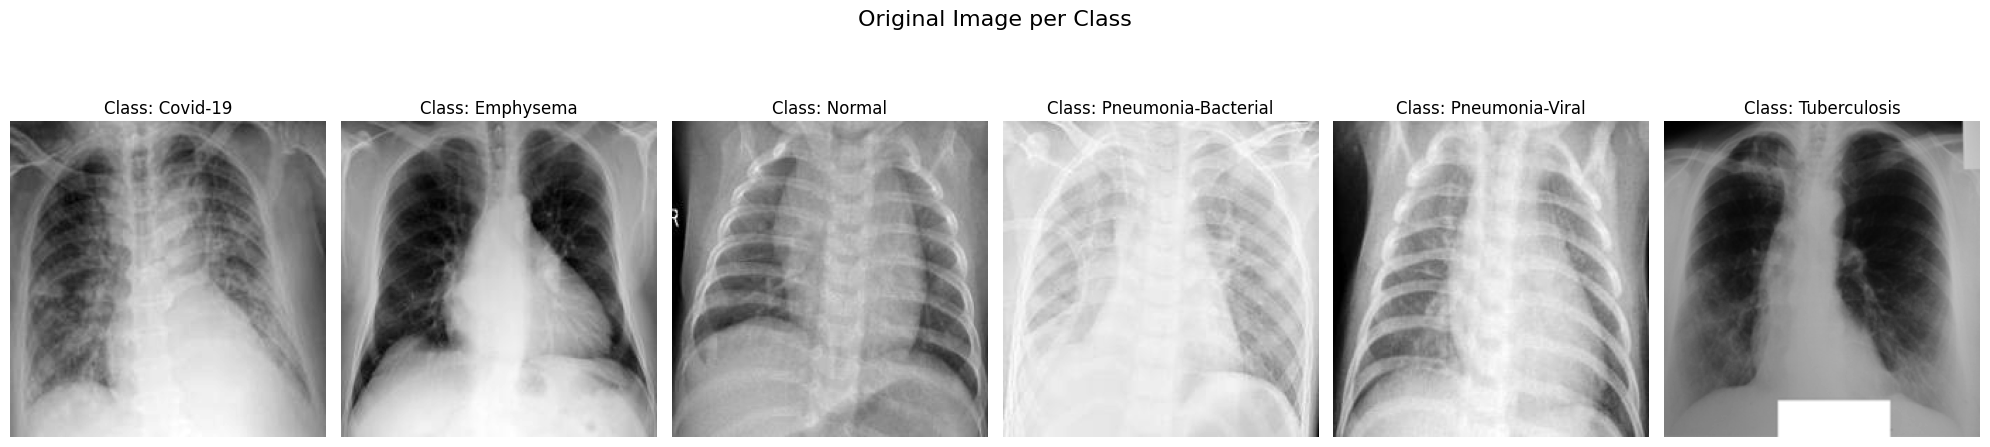

In [8]:
import matplotlib.pyplot as plt
import os
from torchvision.datasets import ImageFolder
from PIL import Image

def show_one_original_image_per_class(dataset):
 
    num_classes = len(dataset.classes)
    images_by_class = {}

    print("Gathering one original image per class...")

    for path, label in dataset.imgs:
        class_name = dataset.classes[label]

        if class_name not in images_by_class:
            images_by_class[class_name] = path

        if len(images_by_class) == num_classes:
            break


    fig, axes = plt.subplots(1, num_classes, figsize=(20, 5))
    fig.suptitle('Original Image per Class', fontsize=16)

 
    for i, class_name in enumerate(sorted(images_by_class.keys())):
        img_path = images_by_class[class_name]


        img = Image.open(img_path)


        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'Class: {class_name}', fontsize=12)
        axes[i].set_axis_off()

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


show_one_original_image_per_class(temp_train_dataset)

### A Quick Look at the Data
Before diving into any training, it's crucial to get a good look at the data we're working with. This step, which is part of (EDA), is just as important as building the model itself.

Here, I wrote a simple function to display one image from each class in our training dataset. This not only helps me verify the data and ensure that ImageFolder loaded it correctly but also gives me a quick visual understanding of what the images in each class look like.

In addition, this early step can help uncover potential issues, such as corrupted images or mislabeled files. Fortunately, our data looks clean and ready for the next stage

In [9]:
train_transform = transforms.Compose([
 
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.GaussianBlur(kernel_size=3),

    transforms.ToTensor(),


    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = ImageFolder(root=os.path.join(data_root, 'train'), transform=train_transform)
val_dataset = ImageFolder(root=os.path.join(data_root, 'val'), transform=test_transform)
test_dataset = ImageFolder(root=os.path.join(data_root, 'test'), transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Preparing the Data for Training
After a quick look at our data, it's time to get it ready for the model. This is a crucial step to ensure effective training.

I defined two sets of transformations: one for the training set and another for the validation and test sets. The reason for this separation is that the training set needs more variety.

For the training set (train_transform):
In addition to basic transformations like resizing to 128x128 and converting to grayscale, I applied data augmentation techniques. These random transformations such as rotation, horizontal flipping, and adding a slight blur—help the model become more robust and flexible. The simple idea here is to teach the model on slightly different versions of the same images, which makes it less prone to overfitting.

As for the validation and test sets (test_transform):
I'm only using basic transformations without any augmentation. This is because our goal is to evaluate the model's performance on data it hasn't seen before, so this data should remain consistent and unaltered.

Finally, I loaded the data using ImageFolder and prepared a DataLoader to create ready-to-use batches for training.

Gathering one image per class...


  0%|          | 0/6 [00:00<?, ?it/s]

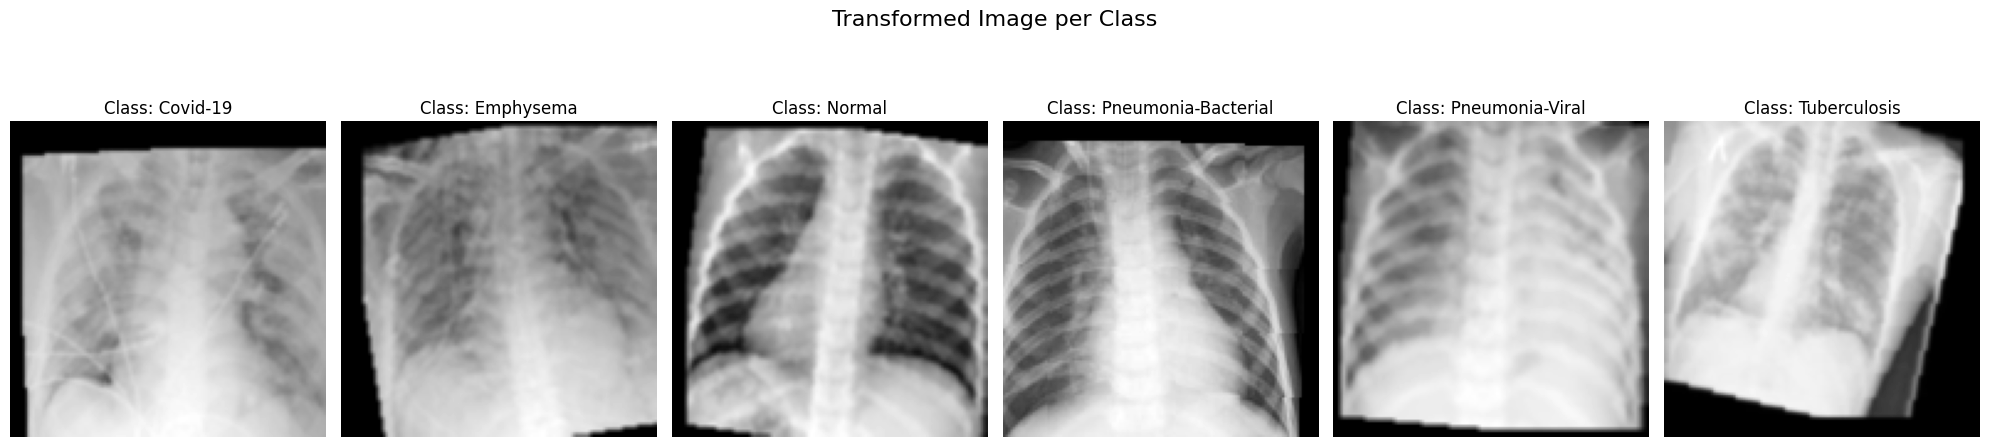

In [10]:

def show_one_image_per_class(data_loader):

    num_classes = len(data_loader.dataset.classes)
    images_by_class = {}

    print("Gathering one image per class...")
 
    with tqdm(total=num_classes) as pbar:

        for images, labels in data_loader:
            for img, lbl in zip(images, labels):
                label_name = data_loader.dataset.classes[lbl]
                if label_name not in images_by_class:
                    images_by_class[label_name] = img
                    pbar.update(1)

        
            if len(images_by_class) == num_classes:
                break


    fig, axes = plt.subplots(1, num_classes, figsize=(20, 5))
    fig.suptitle('Transformed Image per Class', fontsize=16)


    for i, class_name in enumerate(sorted(images_by_class.keys())):
        img = images_by_class[class_name]


        denormalized_img = img / 2 + 0.5
        np_img = denormalized_img.numpy()

        # عرض الصورة
        axes[i].imshow(np.transpose(np_img, (1, 2, 0)).squeeze(), cmap='gray')
        axes[i].set_title(f'Class: {class_name}', fontsize=12)
        axes[i].set_axis_off()

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


show_one_image_per_class(train_loader)

### Preparing the Data for Training
After a quick look at our data, it's time to get it ready for the model. This is a crucial step to ensure effective training.

I defined two sets of transformations: one for the training set and another for the validation and test sets. The reason for this separation is that the training set needs more variety.

For the training set (train_transform):
In addition to basic transformations like resizing to 128x128 and converting to grayscale, I applied data augmentation techniques. These random transformations such as rotation, horizontal flipping, and adding a slight blur—help the model become more robust and flexible. The simple idea here is to teach the model on slightly different versions of the same images, which makes it less prone to overfitting.

As for the validation and test sets (test_transform):
I'm only using basic transformations without any augmentation. This is because our goal is to evaluate the model's performance on data it hasn't seen before, so this data should remain consistent and unaltered.

Finally, I loaded the data using ImageFolder and prepared a DataLoader to create ready-to-use batches for training.

In [11]:
import torch.nn as nn
from torchvision import transforms

class ChestXRayCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(ChestXRayCNN, self).__init__()

        # Block 1
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)


        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)


        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)


        self.conv_skip = nn.Conv2d(32, 128, kernel_size=1, stride=4)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):

        skip_connection = self.conv1(x)
        x = self.bn1(skip_connection)
        x = self.relu1(x)
        x = self.pool1(x)


        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)


        skip_connection = self.conv_skip(skip_connection)


        x = x + skip_connection
        x = self.relu3(x)
        x = self.pool3(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

### CNN with Skip-Connections 
This cell defines the specific architecture I chose for the model used in X-ray image classification. It is a simple yet effective Convolutional Neural Network (CNN), which I designed to accurately extract features across three sequential blocks.

### Architecture Strategy and Functions
* Gradual Feature Extraction: The architecture relies on three consecutive convolutional blocks (32 
→
 64 
→
 128 filters). In each block, I use a BatchNorm layer to improve training stability and MaxPool to reduce dimensions and capture larger features.

* Skip-Connection: This is the most crucial architectural modification in the design. I take low-level features from the first block (after transforming them via conv_skip) and add them to the output of the third block. This mechanism ensures efficient information flow across the network and helps mitigate the Vanishing Gradient problem, thereby boosting classification performance.

* Classifier Head: The features are flattened and passed through two Fully Connected (FC) layers, with Dropout at a rate of 0.5 applied before the final layer. This strong regularization is necessary to prevent Overfitting on the limited medical data.

* In short, this network combines the efficiency of traditional CNNs with the information-linking advantages inspired by ResNet to deliver good performance.

In [12]:
model = ChestXRayCNN(num_classes=len(train_dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1, verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [13]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_acc_max = float('-inf') 
        self.best_model_weights = None
        self.delta = delta 


    def __call__(self, val_accuracy, model):
        score = val_accuracy 
        
        if self.best_score is None:
            self.best_score = score
            self.val_acc_max = score
            self.best_model_weights = model.state_dict()
            if self.verbose:
                print(f'Validation accuracy initialized to {self.best_score:.4f}')
        

        # Note: (best_score - score) > delta  is equivalent to score < best_score - delta
        elif score < self.best_score - self.delta: # 👈 شرط التوقف هو عدم التحسن الكافي (أقل من best_score بـ delta)
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} of {self.patience} (Best Val Acc: {self.best_score:.4f})')
            if self.counter >= self.patience:
                self.early_stop = True
        
        # الحالة الثالثة: حدث تحسن (score >= best_score - delta)
        else:
            if self.verbose and score > self.best_score:
                 print(f'Validation accuracy improved ({self.best_score:.4f} --> {score:.4f}). Saving model...')
            
            self.best_score = score
            self.val_acc_max = score # تحديث أفضل قيمة
            self.best_model_weights = model.state_dict()
            self.counter = 0

early_stopping = EarlyStopping(patience=30, verbose=True, delta=0.0001)



## EarlyStopping: The Guardian Against Overfitting

The function of this class is to monitor the model's performance on validation accuracy val_accuracy at the end of every epoch, and intervene to stop the training early when necessary.

  * **Patience:** I set this parameter to determine the number of consecutive epochs that must pass without a noticeable improvement before I make the decision to stop. In my settings:

 
    I have given the model 30 epochs of waiting after the last improvement to allow it an extra chance.

  * Minimum Improvement delta This parameter defines the minimum amount of improvement that I consider genuine 0.0001 . Any improvement less than this is considered insufficient, and the counter for stopping is incremented. This prevents training from continuing based on marginal, worthless improvements.

Saving the Best Weights:** More important than stopping is saving\! Every time the validation accuracy improves (i.e., is greater than best_score + delta ), I copy and save the model's current weights** (`model.state_dict()`) as the best weights achieved so far.

This guarantees that, when the training process concludes (whether by early stopping or by reaching the maximum number of epochs), I will always use the model that was at its **peak performance on the validation data.

In [14]:

def evaluate_model(model, data_loader, criterion, device):
  model.eval()
  running_loss = 0.0
  correct_predictions = 0
  total_samples = 0
  with torch.no_grad():
      for images, labels in data_loader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          loss = criterion(outputs, labels)
          running_loss += loss.item() * images.size(0)
          _, predicted = torch.max(outputs, 1)
          total_samples += labels.size(0)
          correct_predictions += (predicted == labels).sum().item()

  epoch_loss = running_loss / total_samples
  epoch_accuracy = (correct_predictions / total_samples) * 100
  return epoch_loss, epoch_accuracy

In [15]:

num_epochs = 80
start_epoch = 30 #
for epoch in range(start_epoch, num_epochs):
  model.train()
  running_loss = 0.0
  progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
  for i, (images, labels) in enumerate(progress_bar):
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      progress_bar.set_postfix({'loss': running_loss / (i+1)})

  train_loss, train_accuracy = evaluate_model(model, train_loader, criterion, device)
  val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)

  print(f'Epoch [{epoch+1}/{num_epochs}], '
        f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
        f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

  scheduler.step(val_loss)
  early_stopping(val_loss, model)
  if early_stopping.early_stop:
      print("Early stopping triggered! Loading the best model weights.")
      model.load_state_dict(early_stopping.best_model_weights)
      break

print('----------- Training Finished -----------')


test_loss, test_accuracy = evaluate_model(model, test_loader, criterion, device)
print(f'Final Test Loss: {test_loss:.4f}, Final Test Acc: {test_accuracy:.2f}%')

Epoch 31/80:   0%|          | 0/455 [00:00<?, ?it/s]

Epoch [31/80], Train Loss: 0.8567, Train Acc: 62.85%, Val Loss: 1.0193, Val Acc: 52.97%
Validation accuracy initialized to 1.0193


Epoch 32/80:   0%|          | 0/455 [00:00<?, ?it/s]

Epoch [32/80], Train Loss: 0.6671, Train Acc: 71.69%, Val Loss: 0.7988, Val Acc: 64.93%
EarlyStopping counter: 1 of 30 (Best Val Acc: 1.0193)


Epoch 33/80:   0%|          | 0/455 [00:00<?, ?it/s]

Epoch [33/80], Train Loss: 0.6320, Train Acc: 73.25%, Val Loss: 0.7917, Val Acc: 66.42%
EarlyStopping counter: 2 of 30 (Best Val Acc: 1.0193)


Epoch 34/80:   0%|          | 0/455 [00:00<?, ?it/s]

Epoch [34/80], Train Loss: 0.6464, Train Acc: 69.08%, Val Loss: 0.6614, Val Acc: 68.19%
EarlyStopping counter: 3 of 30 (Best Val Acc: 1.0193)


Epoch 35/80:   0%|          | 0/455 [00:00<?, ?it/s]

Epoch [35/80], Train Loss: 0.6089, Train Acc: 73.85%, Val Loss: 0.6702, Val Acc: 71.05%
EarlyStopping counter: 4 of 30 (Best Val Acc: 1.0193)


Epoch 36/80:   0%|          | 0/455 [00:00<?, ?it/s]

Epoch [36/80], Train Loss: 0.5377, Train Acc: 75.58%, Val Loss: 0.6139, Val Acc: 70.94%
EarlyStopping counter: 5 of 30 (Best Val Acc: 1.0193)


Epoch 37/80:   0%|          | 0/455 [00:00<?, ?it/s]

Epoch [37/80], Train Loss: 0.5455, Train Acc: 76.76%, Val Loss: 0.5999, Val Acc: 73.91%
EarlyStopping counter: 6 of 30 (Best Val Acc: 1.0193)


Epoch 38/80:   0%|          | 0/455 [00:00<?, ?it/s]

Epoch [38/80], Train Loss: 0.4938, Train Acc: 78.38%, Val Loss: 0.5833, Val Acc: 74.71%
EarlyStopping counter: 7 of 30 (Best Val Acc: 1.0193)


Epoch 39/80:   0%|          | 0/455 [00:00<?, ?it/s]

Epoch [39/80], Train Loss: 0.4923, Train Acc: 79.16%, Val Loss: 0.5517, Val Acc: 75.34%
EarlyStopping counter: 8 of 30 (Best Val Acc: 1.0193)


Epoch 40/80:   0%|          | 0/455 [00:00<?, ?it/s]

Epoch [40/80], Train Loss: 0.5005, Train Acc: 79.29%, Val Loss: 0.4981, Val Acc: 79.00%
EarlyStopping counter: 9 of 30 (Best Val Acc: 1.0193)


Epoch 41/80:   0%|          | 0/455 [00:00<?, ?it/s]

Epoch [41/80], Train Loss: 0.4585, Train Acc: 81.03%, Val Loss: 0.4685, Val Acc: 80.43%
EarlyStopping counter: 10 of 30 (Best Val Acc: 1.0193)


Epoch 42/80:   0%|          | 0/455 [00:00<?, ?it/s]

Epoch [42/80], Train Loss: 0.4748, Train Acc: 80.54%, Val Loss: 0.5231, Val Acc: 77.92%
EarlyStopping counter: 11 of 30 (Best Val Acc: 1.0193)


Epoch 43/80:   0%|          | 0/455 [00:00<?, ?it/s]

Epoch [43/80], Train Loss: 0.4266, Train Acc: 82.22%, Val Loss: 0.5492, Val Acc: 78.43%
EarlyStopping counter: 12 of 30 (Best Val Acc: 1.0193)


Epoch 44/80:   0%|          | 0/455 [00:00<?, ?it/s]

Epoch [44/80], Train Loss: 0.4120, Train Acc: 82.33%, Val Loss: 0.4542, Val Acc: 80.55%
EarlyStopping counter: 13 of 30 (Best Val Acc: 1.0193)


Epoch 45/80:   0%|          | 0/455 [00:00<?, ?it/s]

Epoch [45/80], Train Loss: 0.4302, Train Acc: 80.92%, Val Loss: 0.4782, Val Acc: 79.92%
EarlyStopping counter: 14 of 30 (Best Val Acc: 1.0193)


Epoch 46/80:   0%|          | 0/455 [00:00<?, ?it/s]

Epoch [46/80], Train Loss: 0.3981, Train Acc: 83.16%, Val Loss: 0.4336, Val Acc: 81.92%
EarlyStopping counter: 15 of 30 (Best Val Acc: 1.0193)


Epoch 47/80:   0%|          | 0/455 [00:00<?, ?it/s]

Epoch [47/80], Train Loss: 0.4409, Train Acc: 81.45%, Val Loss: 0.4987, Val Acc: 79.00%
EarlyStopping counter: 16 of 30 (Best Val Acc: 1.0193)


Epoch 48/80:   0%|          | 0/455 [00:00<?, ?it/s]

Epoch [48/80], Train Loss: 0.3837, Train Acc: 84.27%, Val Loss: 0.4093, Val Acc: 82.21%
EarlyStopping counter: 17 of 30 (Best Val Acc: 1.0193)


Epoch 49/80:   0%|          | 0/455 [00:00<?, ?it/s]

Epoch [49/80], Train Loss: 0.4083, Train Acc: 82.86%, Val Loss: 0.4122, Val Acc: 83.24%
EarlyStopping counter: 18 of 30 (Best Val Acc: 1.0193)


Epoch 50/80:   0%|          | 0/455 [00:00<?, ?it/s]

Epoch [50/80], Train Loss: 0.3864, Train Acc: 83.81%, Val Loss: 0.4699, Val Acc: 80.84%
EarlyStopping counter: 19 of 30 (Best Val Acc: 1.0193)


Epoch 51/80:   0%|          | 0/455 [00:00<?, ?it/s]

Epoch [51/80], Train Loss: 0.3648, Train Acc: 84.96%, Val Loss: 0.4079, Val Acc: 82.49%
EarlyStopping counter: 20 of 30 (Best Val Acc: 1.0193)


Epoch 52/80:   0%|          | 0/455 [00:00<?, ?it/s]

Epoch [52/80], Train Loss: 0.3697, Train Acc: 85.17%, Val Loss: 0.3866, Val Acc: 83.87%
EarlyStopping counter: 21 of 30 (Best Val Acc: 1.0193)


Epoch 53/80:   0%|          | 0/455 [00:00<?, ?it/s]

Epoch [53/80], Train Loss: 0.3594, Train Acc: 84.70%, Val Loss: 0.4053, Val Acc: 83.52%
EarlyStopping counter: 22 of 30 (Best Val Acc: 1.0193)


Epoch 54/80:   0%|          | 0/455 [00:00<?, ?it/s]

Epoch [54/80], Train Loss: 0.3530, Train Acc: 85.47%, Val Loss: 0.4054, Val Acc: 83.07%
EarlyStopping counter: 23 of 30 (Best Val Acc: 1.0193)


Epoch 55/80:   0%|          | 0/455 [00:00<?, ?it/s]

Epoch [55/80], Train Loss: 0.3449, Train Acc: 85.47%, Val Loss: 0.3911, Val Acc: 84.15%
EarlyStopping counter: 24 of 30 (Best Val Acc: 1.0193)


Epoch 56/80:   0%|          | 0/455 [00:00<?, ?it/s]

Epoch [56/80], Train Loss: 0.3919, Train Acc: 83.68%, Val Loss: 0.4315, Val Acc: 83.07%
EarlyStopping counter: 25 of 30 (Best Val Acc: 1.0193)


Epoch 57/80:   0%|          | 0/455 [00:00<?, ?it/s]

Epoch [57/80], Train Loss: 0.3142, Train Acc: 86.84%, Val Loss: 0.3690, Val Acc: 84.84%
EarlyStopping counter: 26 of 30 (Best Val Acc: 1.0193)


Epoch 58/80:   0%|          | 0/455 [00:00<?, ?it/s]

Epoch [58/80], Train Loss: 0.3078, Train Acc: 87.14%, Val Loss: 0.3693, Val Acc: 84.78%
EarlyStopping counter: 27 of 30 (Best Val Acc: 1.0193)


Epoch 59/80:   0%|          | 0/455 [00:00<?, ?it/s]

Epoch [59/80], Train Loss: 0.3023, Train Acc: 87.59%, Val Loss: 0.3677, Val Acc: 85.41%
EarlyStopping counter: 28 of 30 (Best Val Acc: 1.0193)


Epoch 60/80:   0%|          | 0/455 [00:00<?, ?it/s]

Epoch [60/80], Train Loss: 0.3037, Train Acc: 87.54%, Val Loss: 0.3591, Val Acc: 85.01%
EarlyStopping counter: 29 of 30 (Best Val Acc: 1.0193)


Epoch 61/80:   0%|          | 0/455 [00:00<?, ?it/s]

Epoch [61/80], Train Loss: 0.3025, Train Acc: 87.57%, Val Loss: 0.3575, Val Acc: 85.76%
EarlyStopping counter: 30 of 30 (Best Val Acc: 1.0193)
Early stopping triggered! Loading the best model weights.
----------- Training Finished -----------
Final Test Loss: 0.3097, Final Test Acc: 87.16%


------------------------------------------------------------
Final Test Accuracy: 87.16%
Precision: 0.8723
Recall: 0.8740
F1-Score: 0.8727


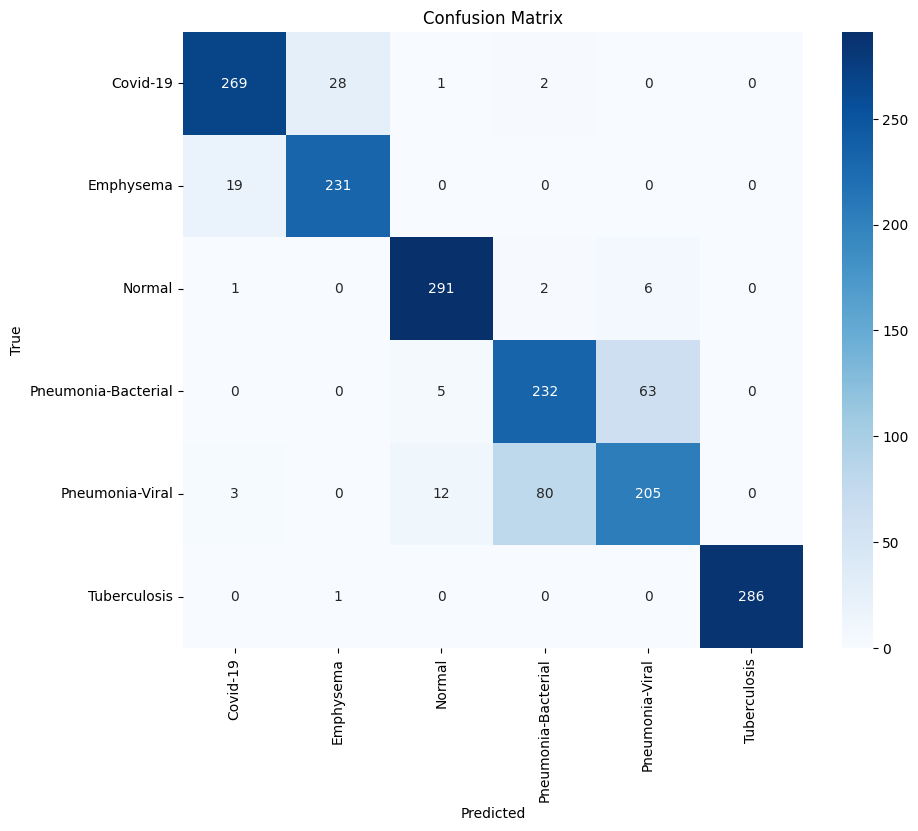

In [16]:

def final_evaluation(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * (np.array(all_preds) == np.array(all_labels)).sum() / len(all_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro', zero_division=0)

    print('---' * 20)
    print(f'Final Test Accuracy: {accuracy:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-Score: {f1:.4f}')

    # Visualize Confusion Matrix
    class_names = loader.dataset.classes
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

final_evaluation(model, test_loader, device)




In [17]:

model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
NUM_CLASSES = 6
IN_CHANNELS = 3
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, NUM_CLASSES)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"EfficientNet-B0 model  and {NUM_CLASSES} classes.")

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 88.9MB/s]


EfficientNet-B0 model  and 6 classes.


In [18]:

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [19]:
import os
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)


def repeat_channel(x):

    return x.repeat(3, 1, 1)


train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),

    transforms.Lambda(repeat_channel),

    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])


test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),

    transforms.Lambda(repeat_channel),

    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])


train_dataset = ImageFolder(root=os.path.join(data_root, 'train'), transform=train_transform)
val_dataset = ImageFolder(root=os.path.join(data_root, 'val'), transform=test_transform)
test_dataset = ImageFolder(root=os.path.join(data_root, 'test'), transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=16,num_workers=0, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16,num_workers=0, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16,num_workers=0, shuffle=False)

In [20]:
early_stopping = EarlyStopping(patience=30, verbose=True, delta=0.0001)

In [21]:

num_epochs = 80 

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for i, (images, labels) in enumerate(progress_bar):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        progress_bar.set_postfix({'loss': running_loss / (i+1)})

    train_loss, train_accuracy = evaluate_model(model, train_loader, criterion, device)
    val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

    scheduler.step(val_loss)
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered! Loading the best model weights.")
        model.load_state_dict(early_stopping.best_model_weights)
        break

print('Finished -----------')


test_loss, test_accuracy = evaluate_model(model, test_loader, criterion, device)
print(f'Final Test Loss: {test_loss:.4f}, Final Test Acc: {test_accuracy:.2f}%')


Epoch 1/80:   0%|          | 0/910 [00:00<?, ?it/s]

Epoch [1/80], Train Loss: 0.3984, Train Acc: 82.85%, Val Loss: 0.4528, Val Acc: 81.64%
Validation accuracy initialized to 0.4528


Epoch 2/80:   0%|          | 0/910 [00:00<?, ?it/s]

Epoch [2/80], Train Loss: 0.3629, Train Acc: 84.49%, Val Loss: 0.3811, Val Acc: 84.55%
EarlyStopping counter: 1 of 30 (Best Val Acc: 0.4528)


Epoch 3/80:   0%|          | 0/910 [00:00<?, ?it/s]

Epoch [3/80], Train Loss: 0.3067, Train Acc: 87.81%, Val Loss: 0.3903, Val Acc: 86.10%
EarlyStopping counter: 2 of 30 (Best Val Acc: 0.4528)


Epoch 4/80:   0%|          | 0/910 [00:00<?, ?it/s]

Epoch [4/80], Train Loss: 0.2570, Train Acc: 89.59%, Val Loss: 0.3239, Val Acc: 85.93%
EarlyStopping counter: 3 of 30 (Best Val Acc: 0.4528)


Epoch 5/80:   0%|          | 0/910 [00:00<?, ?it/s]

Epoch [5/80], Train Loss: 0.2922, Train Acc: 88.33%, Val Loss: 0.3297, Val Acc: 87.36%
EarlyStopping counter: 4 of 30 (Best Val Acc: 0.4528)


Epoch 6/80:   0%|          | 0/910 [00:00<?, ?it/s]

Epoch [6/80], Train Loss: 0.2163, Train Acc: 91.47%, Val Loss: 0.2824, Val Acc: 88.50%
EarlyStopping counter: 5 of 30 (Best Val Acc: 0.4528)


Epoch 7/80:   0%|          | 0/910 [00:00<?, ?it/s]

Epoch [7/80], Train Loss: 0.2574, Train Acc: 89.57%, Val Loss: 0.3780, Val Acc: 86.04%
EarlyStopping counter: 6 of 30 (Best Val Acc: 0.4528)


Epoch 8/80:   0%|          | 0/910 [00:00<?, ?it/s]

Epoch [8/80], Train Loss: 0.2047, Train Acc: 91.42%, Val Loss: 0.3291, Val Acc: 88.62%
EarlyStopping counter: 7 of 30 (Best Val Acc: 0.4528)


Epoch 9/80:   0%|          | 0/910 [00:00<?, ?it/s]

Epoch [9/80], Train Loss: 0.2137, Train Acc: 91.18%, Val Loss: 0.2823, Val Acc: 88.84%
EarlyStopping counter: 8 of 30 (Best Val Acc: 0.4528)


Epoch 10/80:   0%|          | 0/910 [00:00<?, ?it/s]

Epoch [10/80], Train Loss: 0.2161, Train Acc: 91.52%, Val Loss: 0.3502, Val Acc: 87.24%
EarlyStopping counter: 9 of 30 (Best Val Acc: 0.4528)


Epoch 11/80:   0%|          | 0/910 [00:00<?, ?it/s]

Epoch [11/80], Train Loss: 0.1420, Train Acc: 94.51%, Val Loss: 0.2780, Val Acc: 89.93%
EarlyStopping counter: 10 of 30 (Best Val Acc: 0.4528)


Epoch 12/80:   0%|          | 0/910 [00:00<?, ?it/s]

Epoch [12/80], Train Loss: 0.1442, Train Acc: 94.10%, Val Loss: 0.3225, Val Acc: 88.84%
EarlyStopping counter: 11 of 30 (Best Val Acc: 0.4528)


Epoch 13/80:   0%|          | 0/910 [00:00<?, ?it/s]

Epoch [13/80], Train Loss: 0.1308, Train Acc: 94.81%, Val Loss: 0.2503, Val Acc: 90.45%
EarlyStopping counter: 12 of 30 (Best Val Acc: 0.4528)


Epoch 14/80:   0%|          | 0/910 [00:00<?, ?it/s]

Epoch [14/80], Train Loss: 0.1477, Train Acc: 94.30%, Val Loss: 0.3409, Val Acc: 88.22%
EarlyStopping counter: 13 of 30 (Best Val Acc: 0.4528)


Epoch 15/80:   0%|          | 0/910 [00:00<?, ?it/s]

Epoch [15/80], Train Loss: 0.1451, Train Acc: 94.58%, Val Loss: 0.2693, Val Acc: 89.36%
EarlyStopping counter: 14 of 30 (Best Val Acc: 0.4528)


Epoch 16/80:   0%|          | 0/910 [00:00<?, ?it/s]

Epoch [16/80], Train Loss: 0.1163, Train Acc: 95.82%, Val Loss: 0.2464, Val Acc: 91.08%
EarlyStopping counter: 15 of 30 (Best Val Acc: 0.4528)


Epoch 17/80:   0%|          | 0/910 [00:00<?, ?it/s]

Epoch [17/80], Train Loss: 0.1185, Train Acc: 95.48%, Val Loss: 0.2716, Val Acc: 89.65%
EarlyStopping counter: 16 of 30 (Best Val Acc: 0.4528)


Epoch 18/80:   0%|          | 0/910 [00:00<?, ?it/s]

Epoch [18/80], Train Loss: 0.1225, Train Acc: 95.22%, Val Loss: 0.2863, Val Acc: 88.84%
EarlyStopping counter: 17 of 30 (Best Val Acc: 0.4528)


Epoch 19/80:   0%|          | 0/910 [00:00<?, ?it/s]

Epoch [19/80], Train Loss: 0.0831, Train Acc: 96.90%, Val Loss: 0.2613, Val Acc: 91.25%
EarlyStopping counter: 18 of 30 (Best Val Acc: 0.4528)


Epoch 20/80:   0%|          | 0/910 [00:00<?, ?it/s]

Epoch [20/80], Train Loss: 0.0810, Train Acc: 97.05%, Val Loss: 0.2237, Val Acc: 92.62%
EarlyStopping counter: 19 of 30 (Best Val Acc: 0.4528)


Epoch 21/80:   0%|          | 0/910 [00:00<?, ?it/s]

Epoch [21/80], Train Loss: 0.0840, Train Acc: 96.77%, Val Loss: 0.2901, Val Acc: 91.53%
EarlyStopping counter: 20 of 30 (Best Val Acc: 0.4528)


Epoch 22/80:   0%|          | 0/910 [00:00<?, ?it/s]

Epoch [22/80], Train Loss: 0.1021, Train Acc: 96.01%, Val Loss: 0.3286, Val Acc: 90.27%
EarlyStopping counter: 21 of 30 (Best Val Acc: 0.4528)


Epoch 23/80:   0%|          | 0/910 [00:00<?, ?it/s]

Epoch [23/80], Train Loss: 0.0720, Train Acc: 97.46%, Val Loss: 0.2722, Val Acc: 91.53%
EarlyStopping counter: 22 of 30 (Best Val Acc: 0.4528)


Epoch 24/80:   0%|          | 0/910 [00:00<?, ?it/s]

Epoch [24/80], Train Loss: 0.0687, Train Acc: 97.47%, Val Loss: 0.2768, Val Acc: 90.96%
EarlyStopping counter: 23 of 30 (Best Val Acc: 0.4528)


Epoch 25/80:   0%|          | 0/910 [00:00<?, ?it/s]

Epoch [25/80], Train Loss: 0.0633, Train Acc: 97.77%, Val Loss: 0.2751, Val Acc: 91.59%
EarlyStopping counter: 24 of 30 (Best Val Acc: 0.4528)


Epoch 26/80:   0%|          | 0/910 [00:00<?, ?it/s]

Epoch [26/80], Train Loss: 0.0571, Train Acc: 97.91%, Val Loss: 0.2380, Val Acc: 92.39%
EarlyStopping counter: 25 of 30 (Best Val Acc: 0.4528)


Epoch 27/80:   0%|          | 0/910 [00:00<?, ?it/s]

Epoch [27/80], Train Loss: 0.0744, Train Acc: 97.04%, Val Loss: 0.2570, Val Acc: 91.48%
EarlyStopping counter: 26 of 30 (Best Val Acc: 0.4528)


Epoch 28/80:   0%|          | 0/910 [00:00<?, ?it/s]

Epoch [28/80], Train Loss: 0.0476, Train Acc: 98.21%, Val Loss: 0.2231, Val Acc: 93.94%
EarlyStopping counter: 27 of 30 (Best Val Acc: 0.4528)


Epoch 29/80:   0%|          | 0/910 [00:00<?, ?it/s]

Epoch [29/80], Train Loss: 0.0518, Train Acc: 98.13%, Val Loss: 0.2524, Val Acc: 93.31%
EarlyStopping counter: 28 of 30 (Best Val Acc: 0.4528)


Epoch 30/80:   0%|          | 0/910 [00:00<?, ?it/s]

Epoch [30/80], Train Loss: 0.0627, Train Acc: 97.61%, Val Loss: 0.2715, Val Acc: 91.48%
EarlyStopping counter: 29 of 30 (Best Val Acc: 0.4528)


Epoch 31/80:   0%|          | 0/910 [00:00<?, ?it/s]

Epoch [31/80], Train Loss: 0.0494, Train Acc: 98.23%, Val Loss: 0.2389, Val Acc: 92.56%
EarlyStopping counter: 30 of 30 (Best Val Acc: 0.4528)
Early stopping triggered! Loading the best model weights.
Finished -----------
Final Test Loss: 0.2042, Final Test Acc: 94.13%


------------------------------------------------------------
Final Test Accuracy: 94.13%
Precision: 0.9418
Recall: 0.9423
F1-Score: 0.9420


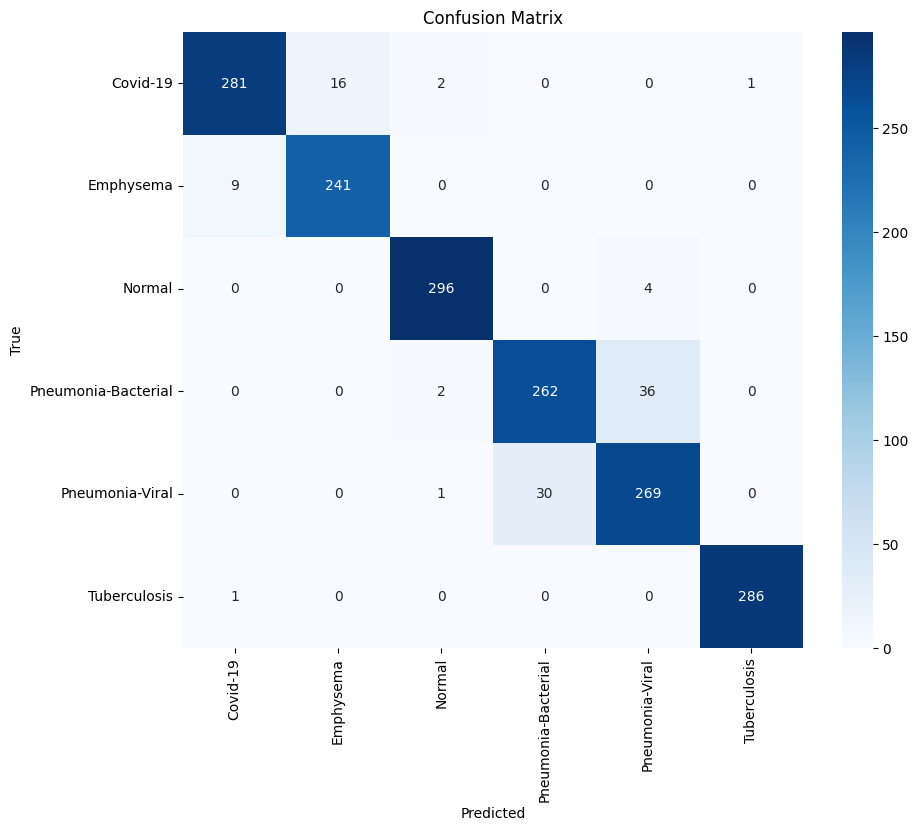

In [22]:
final_evaluation(model, test_loader, device)